In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from __future__ import division

In [2]:
def getData(files):
    f = open("data/"+str(files), "r")
    f1 = f.readlines()
    del f1[0:4]
    a = np.asarray(f1)
    table = []
    for i in range(0, len(a)):
        b = a[i][0:-1].split('\t')
        c = map(float, b[0:6])
        d = np.asarray(c)
        table.append(d)
    table = np.asarray(table)
    pd.set_option('display.float_format', lambda x: '%.6e' % x)
    df = pd.DataFrame(table, columns=['t1', 'v1', 'w1', 't2', 'v2', 'w2'])
    return df

In [3]:
def getChiSq(y, y_fit, sigma):
    chi_sq = 0
    for i in range(len(y)):
        chi_sq += ( (y[i] - y_fit[i]) / sigma[i] )**2
    return chi_sq

In [4]:
def getRedChi2(y, y_fit, sigma, numPar=2):
    chi_sq = getChiSq(y, y_fit, sigma)
    red_chi_sq = chi_sq / (len(y) - numPar)
    p = chi2.pdf(chi_sq, df=(len(y) - numPar))
    print 'reduced chi-square =', '%.2f'%(red_chi_sq), 'p-value =', '%.2f'%(p)
    return red_chi_sq

In [5]:
def integrate(binwidth, yarray, low, high):
    s = 0
    interval = (int)((high - low)/binwidth)
    for i in range(0, interval):
        s = s + binwidth * yarray[i]
    return s

In [86]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [9]:
df = getData('MUO_long.dat')
df.eval('dt = t2 - t1', inplace=True)

In [7]:
def decay(x, tau, c):
    return np.exp(- x / tau) + c

In [87]:
df = applyCut(df, 'v1 > 0.05', 'v1 > 0.05')
df = applyCut(df, 'v2 > 0.05', 'v2 > 0.05')

v1 > 0.05 940307  fraction kept: 98.0
v2 > 0.05 82487  fraction kept: 8.8


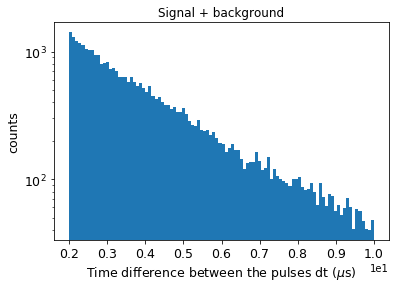

In [88]:
plt.hist(df['dt']*1e6, bins = 100, range=(2, 10))
plt.xlabel('Time difference between the pulses dt ($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Signal + background')
plt.yscale('log')

Text(0.5,1,'Signal + background')

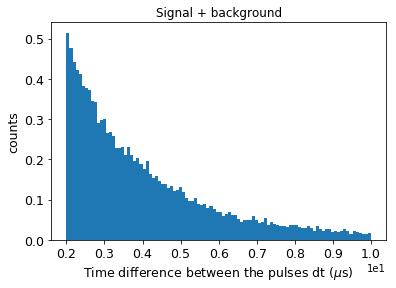

In [89]:
plt.hist(df['dt']*1e6, bins = 100, range=(2, 10), normed=True)
plt.xlabel('Time difference between the pulses dt ($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Signal + background')

In [90]:
y, binEdges = np.histogram(df['dt']*1e6, bins=100, range=(2, 10), density=True)
x = []
for i in range(len(y)):
    x.append((binEdges[i] + binEdges[i+1]) / 2)

In [91]:
popt, pcov = curve_fit(decay, x, y) # pcov is the covariance matrix for the fit parameters

print 'Parameters of binned linear fit: tau =','%.3f'%(popt[0]),'micro sec,',' c =','%.3f'%(popt[1]),\
       ' error on tau =', '%.4f'%(np.sqrt(pcov[0][0])), 'micro sec,', \
       'error on c =', '%.4f'%(np.sqrt(pcov[1][1]))

Parameters of binned linear fit: tau = 2.511 micro sec,  c = -0.011  error on tau = 0.0397 micro sec, error on c = 0.0039


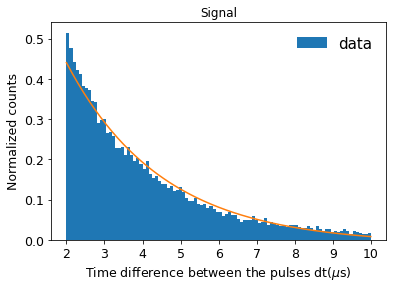

In [92]:
arange = np.arange(2, 10.05, 0.05)
plt.hist(binEdges[:-1], binEdges, weights=y, label='data')
plt.plot(arange, decay(arange, popt[0], popt[1])) #label='fit: $log_{10}(y) = -0.58 \mu s^{-1} x + 1.10$ \
         #\n cannot set intercept to 0')
plt.xlabel('Time difference between the pulses dt($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('Normalized counts', fontsize=12.5)
#plt.ylabel('$log_{10}$(counts)', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.title('Signal')
plt.legend(prop={'size': 15}, frameon=False, loc='best')

In [93]:
low = 6
high = 10
bins = 50
binWidth = (high - low) / bins

Text(0.5,1,'Signal + background')

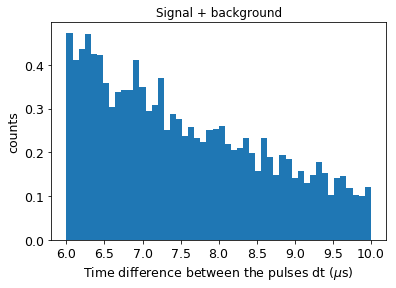

In [94]:
plt.hist(df['dt']*1e6, bins = bins, range=(low, high), normed=True)
plt.xlabel('Time difference between the pulses dt ($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.title('Signal + background')

In [95]:
y, binEdges = np.histogram(df['dt']*1e6, bins=bins, range=(low, high), density=True)
x = []
for i in range(len(y)):
    x.append((binEdges[i] + binEdges[i+1]) / 2)
x = np.asarray(x)

In [96]:
popt, pcov = curve_fit(decay, x, y) # pcov is the covariance matrix for the fit parameters

print 'Parameters of binned linear fit: tau =','%.3f'%(popt[0]),'micro sec,',' c =','%.3f'%(popt[1]),\
       ' error on tau =', '%.4f'%(np.sqrt(pcov[0][0])), 'micro sec,', \
       'error on c =', '%.4f'%(np.sqrt(pcov[1][1]))

Parameters of binned linear fit: tau = 7.756 micro sec,  c = -0.110  error on tau = 16.9661 micro sec, error on c = 0.7959


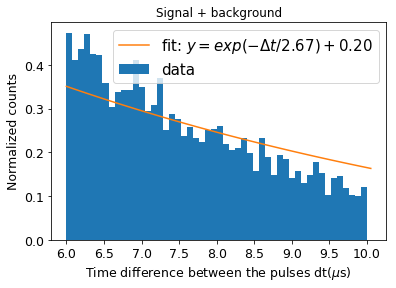

In [97]:
arange = np.arange(6, 10.05, 0.05)
plt.hist(binEdges[:-1], binEdges, weights=y, label='data')
plt.plot(arange, decay(arange, popt[0], popt[1]), label='fit: $y = exp(-\Delta t / 2.67) + 0.20$')
plt.xlabel('Time difference between the pulses dt($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('Normalized counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.title('Signal + background')
plt.legend(prop={'size': 15}, frameon=True, loc='best')

In [81]:
tot = integrate(binWidth, np.histogram(df['dt']*1e6, bins=bins, range=(low, high))[0], low, high)
sigma = np.sqrt(tot * y) / tot

In [82]:
getRedChi2(y, decay(x, popt[0], popt[1]), sigma)

reduced chi-square = 1.39 p-value = 0.01


1.3858704704708804

Fit a linear curve to the background

In [23]:
def linear(x, k, b):
    return k*x+b

Text(0.5,1,'Background')

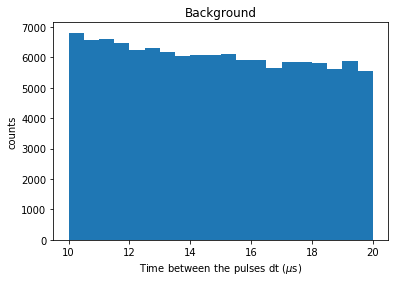

In [53]:
plt.hist(df['dt']*1e6, bins=20, range=(10, 20))
plt.xlabel('Time between the pulses dt ($\mu$s)')
plt.ylabel('counts')
plt.title('Background')

In [40]:
y, binEdges = np.histogram(df['dt']*1e6, bins=20, range=(10, 20))
x = []
for i in range(len(y)):
    x.append((binEdges[i] + binEdges[i+1]) / 2)
x = np.asarray(x)

In [41]:
popt, pcov = curve_fit(linear, x, np.log10(y)) # pcov is the covariance matrix for the fit parameters

k_backg = popt[0]
b_backg = popt[1]

print 'Parameters of binned linear fit: slope =','%.3f'%(popt[0]),'micro sec ^ (-1),',' interceprt =','%.3f'%(popt[1]),\
       ' error on the slope =', '%.4f'%(np.sqrt(pcov[0][0])), 'micro sec ^ (-1),', \
       'error on the intercept =', '%.4f'%(np.sqrt(pcov[1][1]))

Parameters of binned linear fit: slope = -0.008 micro sec ^ (-1),  interceprt = 3.898  error on the slope = 0.0007 micro sec ^ (-1), error on the intercept = 0.0104


Text(0.5,1,'Background')

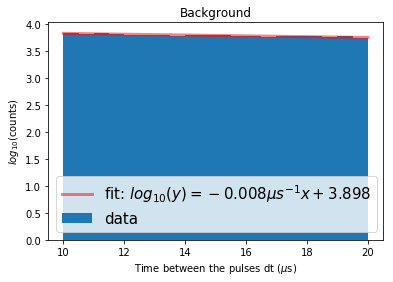

In [50]:
arange = np.arange(10, 21)
plt.hist(binEdges[:-1], binEdges, weights=np.log10(y), label='data')
plt.plot(arange,linear(arange,popt[0],popt[1]),label='fit: $log_{10}(y)= -0.008 \mu s^{-1} x + 3.898$',linewidth=3,alpha=.5,color='r')
plt.xlabel('Time between the pulses dt ($\mu$s)')
plt.ylabel('$log_{10}$(counts)')
plt.legend(prop={'size': 15}, frameon=True, loc='best')
plt.title('Background')

In [34]:
y, binEdges = np.histogram(df['dt']*1e6, bins=20, range=(10, 20), density=True)
popt, pcov = curve_fit(linear, x, np.log10(y))
getRedChi2(y, linear(x, popt[0], popt[1]), 1/(np.sqrt(y)*np.log(10)))

reduced chi-square = 0.71 p-value = 0.06


0.7127452379763739